## Problem Statement

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

### Objectives
1. Analyze genre performance based on ratings and votes. Determine which genres consistently perform well and are most appealing to audiences, guiding the studio's content strategy.

2. Examine the influence of directors on movie ratings. Identify successful directors whose styles or approaches may inspire the studio's productions.

3.Evaluate trends in movie success across time. Leverage the release year alongside rating data to uncover patterns- such as whether older movies or recent releases perform better.

In [1]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3
import zipfile
import os

In [2]:

# Define the path to the zip file
zip_file_path = "zippedData/im.db.zip"
extract_to_path = "im.db" 

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)


In [3]:
# Path to your extracted SQLite database
db_path = "im.db/im.db" 

# Connect to the database
conn = sqlite3.connect(db_path)

### Data Exploration

Let us explore various features in our dataset to help us understand the data we're dealing with better.

In [4]:
# Fetch and list all table names in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Available tables:", tables)

Available tables: [('movie_basics',), ('directors',), ('known_for',), ('movie_akas',), ('movie_ratings',), ('persons',), ('principals',), ('writers',)]


In [5]:
# Inspect the structure of a specific table
cursor.execute("PRAGMA table_info(movie_basics);")
columns = cursor.fetchall()

# Convert the results into a Pandas DataFrame for better readability
columns_df = pd.DataFrame(columns, columns=["cid", "name", "type", "notnull", "dflt_value", "pk"])

print(columns_df)

   cid             name     type  notnull dflt_value  pk
0    0         movie_id     TEXT        0       None   0
1    1    primary_title     TEXT        0       None   0
2    2   original_title     TEXT        0       None   0
3    3       start_year  INTEGER        0       None   0
4    4  runtime_minutes     REAL        0       None   0
5    5           genres     TEXT        0       None   0


### Data Cleaning

We're now going to clean our data so that we can; handle missing values and duplicates, filter outliers as well as validate relationships.

In [6]:
# Load the data 
query = "SELECT * FROM movie_basics"
movie_basics_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM movie_ratings"
movie_ratings_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM directors"
directors_df = pd.read_sql_query(query, conn)

# Check for missing values
print("Missing values in movie_basics:")
print(movie_basics_df.isnull().sum())

print("\nMissing values in movie_ratings:")
print(movie_ratings_df.isnull().sum())

print("\nMissing values in directors:")
print(directors_df.isnull().sum())

Missing values in movie_basics:
movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

Missing values in movie_ratings:
movie_id         0
averagerating    0
numvotes         0
dtype: int64

Missing values in directors:
movie_id     0
person_id    0
dtype: int64


It's only the `movie_basics` table that contains missing values. We'll be ignoring the missing `original_title` as it isn't a crucial feature in our analysis. `runtime_minutes` has a lot of missing values. Here, we'll replace the missing values with the median because it is less affected by outliers. `genres` is a critical column in our analysis and therefore we'll have drop its missing values to avoid compromising the accuracy and validity of the insights we derive from our data.

In [7]:
# Replace missing runtime_minutes with the median
runtime_median = movie_basics_df['runtime_minutes'].median()
movie_basics_df['runtime_minutes'].fillna(runtime_median, inplace=True)

# Drop rows with missing genres
movie_basics_df = movie_basics_df[movie_basics_df['genres'].notnull()]

print("Missing values after cleaning:")
print(movie_basics_df.isnull().sum())

Missing values after cleaning:
movie_id           0
primary_title      0
original_title     2
start_year         0
runtime_minutes    0
genres             0
dtype: int64


In [8]:
# Remove duplicates if any
movie_basics_df = movie_basics_df.drop_duplicates()
movie_ratings_df = movie_ratings_df.drop_duplicates()
directors_df = directors_df.drop_duplicates()

In [9]:
# Remove movies with very few votes to filter outliers
movie_ratings_df = movie_ratings_df[movie_ratings_df['numvotes'] >= 10]

## Data Analysis


The purpose of this analysis is to generate actionable insights for the company's new movie studio by exploring key factors that contribute to box office success. This will involve:
1. Analyzing genre performance based on ratings and votes to identify audience preferences.
2. Examining the influence of directors on movie ratings to highlight creative styles worth emulating.
3. Evaluating trends in movie success across time to uncover patterns that can guide release strategies.

By aligning the findings with these objectives, the studio can make informed decisions to maximize audience appeal and critical acclaim.

## Objective 1

###  Analyze genre performance based on ratings and votes. Determine which genres consistently perform well and are most appealing to audiences, guiding the studio's content strategy.

Let us group the movies by their specific genres. We'll be aggregating metrics such as `avg_rating` and `total_votes` for each genre using an SQL query.

In [10]:
# Group movies by genre and analyze aggregated metrics
query = """
SELECT mb.genres, 
       AVG(mr.averagerating) AS avg_rating, 
       SUM(mr.numvotes) AS total_votes
FROM movie_basics mb
JOIN movie_ratings mr
ON mb.movie_id = mr.movie_id
GROUP BY mb.genres
"""
genres_aggregated_df = pd.read_sql_query(query, conn)

The `genres` column contains a lot of null values. We therefore need to clean this column to drop rows with None and NaN values.
To ensure meaningful insights, we also filtered out genres with low representation (<1000 total votes) to help us focus on genres with significant audience engagement.

In [11]:
# Clean the 'genres' column
genres_aggregated_df['genres'] = genres_aggregated_df['genres'].fillna('Invalid') 
genres_aggregated_df = genres_aggregated_df[~genres_aggregated_df['genres'].isin(['Invalid', 'None'])]

# Filter genres with total_votes <1000
filtered_genres_df = genres_aggregated_df[genres_aggregated_df['total_votes'] > 1000]
filtered_genres_df.head(10)

,genres,avg_rating,total_votes
1,Action,5.757712,329057
3,"Action,Adventure",5.223529,109011
4,"Action,Adventure,Animation",6.562874,3570543
5,"Action,Adventure,Biography",7.061905,999701
6,"Action,Adventure,Comedy",5.554032,7256686
7,"Action,Adventure,Crime",5.755769,1344328
8,"Action,Adventure,Documentary",7.469841,16936
9,"Action,Adventure,Drama",5.691579,4485443
10,"Action,Adventure,Family",5.380000,787657
11,"Action,Adventure,Fantasy",5.371845,9658883


### Ranking Genres Based on Ratings and Votes

This analysis ranks movie genres using a balanced **composite score** (50% average ratings, 50% total votes). Steps followed include:
1. Normalizing `avg_rating` and `total_votes` for comparability.
2. Calculating a composite score to weigh audience engagement and quality.
3. Filtering genres with over 1000 total votes for better representation.
4. Sorting by composite score to identify top-ranked genres.

In [12]:
# Normalize the metrics
genres_aggregated_df['normalized_rating'] = (
    (genres_aggregated_df['avg_rating'] - genres_aggregated_df['avg_rating'].min()) /
    (genres_aggregated_df['avg_rating'].max() - genres_aggregated_df['avg_rating'].min())
)

genres_aggregated_df['normalized_votes'] = (
    (genres_aggregated_df['total_votes'] - genres_aggregated_df['total_votes'].min()) /
    (genres_aggregated_df['total_votes'].max() - genres_aggregated_df['total_votes'].min())
)

# Calculate the composite score (equal weights for ratings and votes)
genres_aggregated_df['composite_score'] = (
    0.5 * genres_aggregated_df['normalized_rating'] +
    0.5 * genres_aggregated_df['normalized_votes']
)

# Filter genres with few votes
filtered_genres_df = genres_aggregated_df[genres_aggregated_df['total_votes'] > 1000]

# Sort genres by the composite score in descending order
ranked_genres_df = filtered_genres_df.sort_values(by='composite_score', ascending=False)
ranked_genres_df.reset_index(drop=True, inplace=True)

ranked_genres_df.head(10)

,genres,avg_rating,total_votes,normalized_rating,normalized_votes,composite_score
0,"Action,Adventure,Sci-Fi",5.655906,23023248,0.531988,1.000000,0.765994
1,Drama,6.494265,8395521,0.636783,0.364654,0.500718
2,"Comedy,Drama,Romance",6.292467,7665463,0.611558,0.332944,0.472251
3,"Adventure,Animation,Comedy",5.936555,8687435,0.567069,0.377333,0.472201
4,"Action,Adventure,Fantasy",5.371845,9658883,0.496481,0.419527,0.458004
5,"Comedy,Drama",6.364119,6462839,0.620515,0.280709,0.450612
6,"Drama,Romance",6.294305,5542760,0.611788,0.240746,0.426267
7,"Animation,Documentary,Mystery",8.200000,1014,0.850000,0.000044,0.425022
8,Comedy,5.777998,6832037,0.547250,0.296745,0.421997
9,"Action,Adventure,Comedy",5.554032,7256686,0.519254,0.315189,0.417222


We'll use a horizontal bar chart to display the top-ranked genres based on their composite scores.

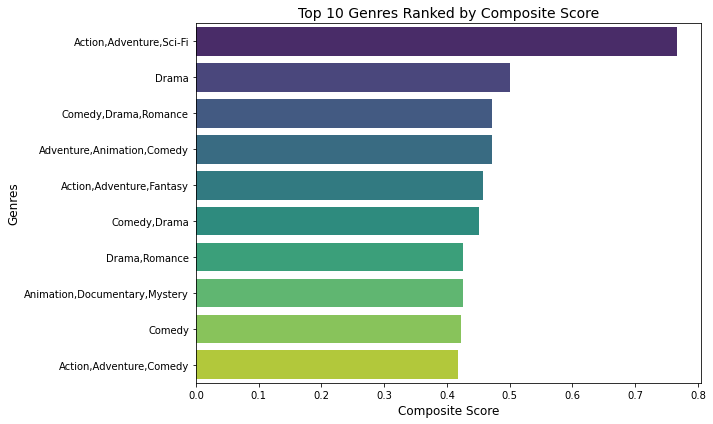

In [13]:
# Select the top 10 genres for visualization
top_genres = ranked_genres_df.head(10)

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='composite_score', 
    y='genres', 
    data=top_genres, 
    palette='viridis'
)

# Add labels and title
plt.xlabel('Composite Score', fontsize=12)
plt.ylabel('Genres', fontsize=12)
plt.title('Top 10 Genres Ranked by Composite Score', fontsize=14)
plt.tight_layout()

plt.show()


### Conclusion

- **Dominance of Core Genre Pairings:**  
  Our analysis shows that combinations featuring *Action* and *Adventure* (e.g., "Action, Adventure, Sci-Fi", "Action, Adventure, Fantasy", "Action, Adventure, Comedy") consistently rank highly. This indicates that these genres form a robust backbone, resonating strongly with audiences regardless of the additional elements paired with them.

- **Versatile Support from Complementary Genres:**  
  Frequently appearing alongside others, genres such as *Drama* and *Comedy* (seen in rows like "Comedy, Drama, Romance", "Comedy, Drama", and "Drama, Romance") seem to enhance emotional depth and broaden appeal. Their recurrent presence suggests that while they may not always lead by themselves, they play a crucial role in enriching the overall film experience.

Overall, these insights indicate that hybrid genre strategies may be key to achieving both critical acclaim and widespread popularity.

### Objective 2:

 **Examine the influence of directors on movie ratings. Identify successful directors whose styles or approaches may inspire the studio's productions.**

In [14]:
# Link directors with their names, ratings, and votes
query = """
SELECT d.person_id AS director_id, 
       p.primary_name AS director_name, 
       AVG(mr.averagerating) AS avg_rating, 
       SUM(mr.numvotes) AS total_votes
FROM directors d
JOIN movie_basics mb ON d.movie_id = mb.movie_id
JOIN movie_ratings mr ON mb.movie_id = mr.movie_id
JOIN persons p ON d.person_id = p.person_id
GROUP BY d.person_id, p.primary_name
"""
directors_aggregated_df = pd.read_sql_query(query, conn)

directors_aggregated_df = directors_aggregated_df[directors_aggregated_df['total_votes'] > 1000]

# Sort directors by avg_rating in descending order
directors_aggregated_df = directors_aggregated_df.sort_values(by='avg_rating', ascending=False)

# Reset the index to remove the unnamed column
directors_aggregated_df.reset_index(drop=True, inplace=True)

directors_aggregated_df.head(10)

,director_id,director_name,avg_rating,total_votes
0,nm6748553,Karzan Kardozi,9.6,1339
1,nm8961212,Lauren Ross,9.5,2487
2,nm6213280,Daniel Gabriel,9.5,1234
3,nm8145653,John Griesser,9.5,2487
4,nm8359417,Chathra Weeraman,9.5,6509
5,nm8529623,Bharatha Hettiarachchi,9.5,6509
6,nm8961211,Jean Griesser,9.5,2487
7,nm9988436,Amudhavan Karuppiah,9.4,19258
8,nm6041686,Anjana Krishnakumar,9.4,19258
9,nm10716125,A.K.S. Nambiar,9.3,1174


Let's introduce a composite score to balance both average ratings and total votes. This ensures that directors with high ratings but low votes and those with high votes but slightly lower ratings are fairly evaluated.

In [15]:
# Normalize the metrics
directors_aggregated_df['normalized_rating'] = (
    (directors_aggregated_df['avg_rating'] - directors_aggregated_df['avg_rating'].min()) /
    (directors_aggregated_df['avg_rating'].max() - directors_aggregated_df['avg_rating'].min())
)

directors_aggregated_df['normalized_votes'] = (
    (directors_aggregated_df['total_votes'] - directors_aggregated_df['total_votes'].min()) /
    (directors_aggregated_df['total_votes'].max() - directors_aggregated_df['total_votes'].min())
)

# Calculate the composite score
directors_aggregated_df['composite_score'] = (
    0.5 * directors_aggregated_df['normalized_rating'] +
    0.5 * directors_aggregated_df['normalized_votes']
)

# Sort directors by the composite score in descending order
ranked_directors_df = directors_aggregated_df.sort_values(by='composite_score', ascending=False)
ranked_directors_df.reset_index(drop=True, inplace=True)

ranked_directors_df[['director_name', 'avg_rating', 'total_votes', 'composite_score']].head(10)

,director_name,avg_rating,total_votes,composite_score
0,Anthony Russo,8.246667,18421593,0.915447
1,Joe Russo,8.246667,18421593,0.915447
2,James Gunn,6.266667,18640459,0.806202
3,Christopher Nolan,8.437500,10457390,0.712903
4,Matthew Vaughn,7.500000,9962120,0.645112
5,Peter Jackson,7.743750,8634677,0.623675
6,Zack Snyder,6.619231,10576977,0.610398
7,James Mangold,7.716667,6014842,0.551824
8,Christopher Miller,7.421053,6565719,0.549414
9,Phil Lord,7.421053,6565719,0.549414


We'll use a lollipop chart to visualize our analysis.

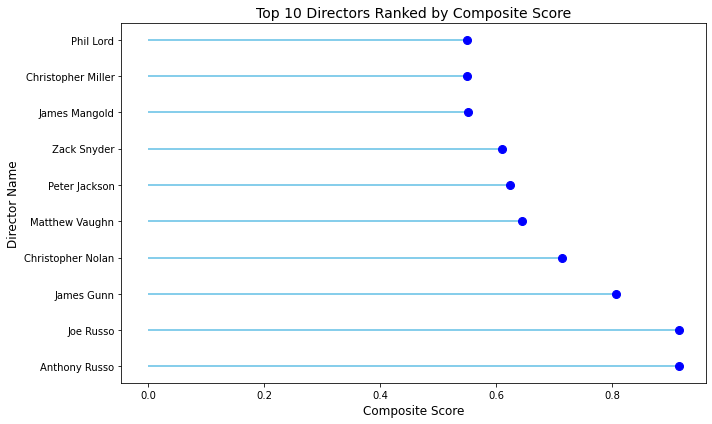

In [16]:
# Select the top 10 directors for visualization
top_directors = ranked_directors_df.head(10)

# Create a lollipop chart
plt.figure(figsize=(10, 6))
plt.hlines(y=top_directors['director_name'], xmin=0, xmax=top_directors['composite_score'], color='skyblue', linewidth=2)
plt.plot(top_directors['composite_score'], top_directors['director_name'], "o", markersize=8, color='blue')

# Add labels and title
plt.xlabel('Composite Score', fontsize=12)
plt.ylabel('Director Name', fontsize=12)
plt.title('Top 10 Directors Ranked by Composite Score', fontsize=14)
plt.tight_layout()

plt.show()

### Conclusion

- **Blockbuster Influence:**  
  The Russo brothers lead the rankings with a composite score of 0.92, highlighting that films which not only earn high ratings but also attract a massive audience can significantly elevate a director’s overall performance.

- **Performance Trade-offs:**  
  While directors like Christopher Nolan receive exceptional ratings (8.44), their composite scores (0.71) suggest that critical acclaim alone may not fully reflect audience reach. Conversely, directors such as James Gunn, with lower average ratings, achieve high composite scores (0.81) by securing extensive audience votes.

- **Balanced Evaluation:**  
  By combining normalized ratings and vote counts, the composite metric captures a nuanced view of a director's success—rewarding both quality and audience engagement. This balanced perspective underscores the value of considering multiple dimensions when assessing cinematic impact.

## Objective 3:

**Evaluate trends in movie success across time. Leverage the release year alongside rating data to uncover patterns- such as whether older movies or recent releases perform better.**

In [17]:
# Query to extract release years, ratings, and votes
query = """
SELECT mb.start_year AS release_year, 
       AVG(mr.averagerating) AS avg_rating, 
       SUM(mr.numvotes) AS total_votes
FROM movie_basics mb
JOIN movie_ratings mr ON mb.movie_id = mr.movie_id
WHERE mb.start_year IS NOT NULL
GROUP BY mb.start_year
ORDER BY mb.start_year
"""
trends_over_time_df = pd.read_sql_query(query, conn)

trends_over_time_df.head(10)

,release_year,avg_rating,total_votes
0,2010,6.259585,30485759
1,2011,6.290134,32741501
2,2012,6.297057,32726315
3,2013,6.287259,35638577
4,2014,6.319806,34382294
5,2015,6.265894,26167370
6,2016,6.347300,26621703
7,2017,6.397624,21901644
8,2018,6.415599,16507889
9,2019,6.703578,3070541


Let's visualize our output using a line plot.

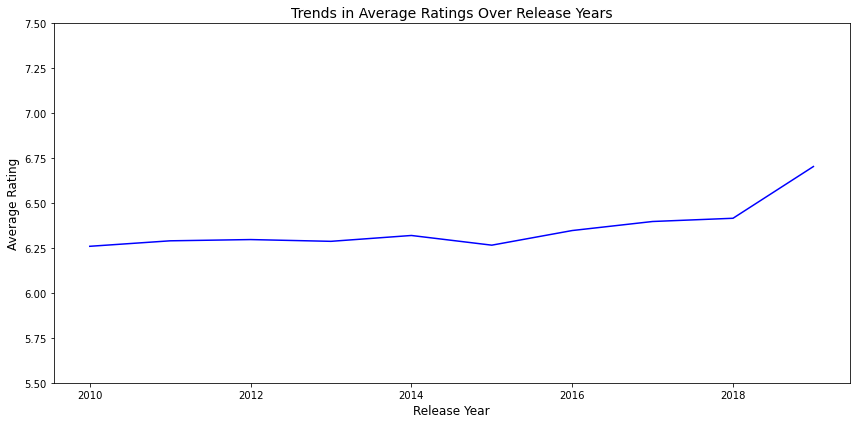

In [18]:
# Plot the relationship between release year and average rating
plt.figure(figsize=(12, 6))

# Create a line plot
sns.lineplot(
    x='release_year', 
    y='avg_rating', 
    data=trends_over_time_df, 
    color='blue'
)

# Add labels and title
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.title('Trends in Average Ratings Over Release Years', fontsize=14)

# Adjust the y-axis limits based on the range of our data
plt.ylim(5.5, 7.5) 

plt.tight_layout()

plt.show()

### Conclusion

- **Minimal Variation in Ratings:**  
  Although average ratings show a slight upward trend (from 6.26 in 2010 to 6.70 in 2019), the change is modest, suggesting that films across these years are generally perceived similarly in quality.

- **Impact of Time on Votes:**  
  The lower total votes for newer films likely stem from less time to accumulate feedback compared to older titles, making it difficult to draw direct performance comparisons solely based on vote counts.

- **Overall Insight:**  
  The analysis does not provide strong evidence that either older or more recent movies consistently outperform the other in terms of audience reception. Other factors may be needed to fully understand trends in movie success over time.

### **Hypothesis Testing**

**Hypothesis 1**: Movies with higher average ratings tend to receive more votes compared to movies with lower average ratings.

**Null Hypothesis**
* There is no relationship between average ratings and the number of votes.

**Alternative Hypothesis**
* Movies with higher average ratings receive significantly more votes.


In [19]:
from scipy.stats import pearsonr

# Extract relevant columns
ratings = movie_ratings_df['averagerating']
votes = movie_ratings_df['numvotes']

# Perform Pearson correlation test
correlation, p_value = pearsonr(ratings, votes)

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant relationship between ratings and votes.")
else:
    print("Fail to reject the null hypothesis: No significant relationship between ratings and votes.")

Correlation coefficient: 0.05862963383194811
P-value: 3.950272475901306e-48
Reject the null hypothesis: There is a significant relationship between ratings and votes.


While the relationship exists, the weak correlation (0.059) suggests that other factors e.g., marketing, genre, or popularity likely play a much larger role in determining the number of votes a movie receives.

**Hypothesis 2**: Do movies with shorter runtimes get higher average ratings?

**Null Hypothesis (H0)**
* There is no relationship between movie runtime and average ratings.

**Alternative Hypothesis(H1)**
* Movies with shorter runtimes receive higher average ratings.


In [20]:
# Merge the DataFrames to align runtimes and ratings
merged_df = pd.merge(movie_basics_df, movie_ratings_df, on='movie_id', how='inner')

# Extract relevant columns
runtimes = merged_df['runtime_minutes']
ratings = merged_df['averagerating']

# Perform Spearman correlation test
from scipy.stats import spearmanr
correlation, p_value = spearmanr(runtimes, ratings)

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant relationship between runtime and ratings.")
else:
    print("Fail to reject the null hypothesis: No significant relationship between runtime and ratings.")

Spearman Correlation Coefficient: -0.017594638652671135
P-value: 1.3301218114501754e-05
Reject the null hypothesis: There is a significant relationship between runtime and ratings.


There is a statistically significant but very weak negative correlation between movie runtime and average ratings (Spearman correlation coefficient = -0.018). This suggests that shorter runtimes are slightly associated with higher ratings, but the effect is so small that it's almost negligible.

### OVERALL CONCLUSION

Our analysis provides several actionable insights for the new movie studio:

- **Hybrid Genre Strategy:**  
  Films that combine robust, high-energy genres like Action and Adventure with complementary elements (such as Sci-Fi, Drama, or Comedy) consistently resonate with audiences. This hybrid approach not only drives broad appeal but also enriches storytelling, making it a promising direction for new content.

- **Balanced Director Performance:**  
  The success of top directors underscores the importance of balancing critical quality with wide audience engagement. Directors who achieve high composite scores—reflecting both strong ratings and substantial viewer participation (as seen with the Russo brothers)—demonstrate that blockbuster appeal is as much about attracting large audiences as it is about garnering critical acclaim.

- **Consistency Across Time:**  
  Although there is a modest upward trend in average ratings over recent years, this variation is minimal. The similar levels of film quality across different eras imply that factors such as innovative genre blends and director expertise are likely more significant differentiators than the release year alone.

**Actionable Insight:**  
For the studio to thrive in a competitive market, the strategy should center on developing hybrid genre films that effectively merge high-energy action with nuanced, supportive elements, while also partnering with directors who can achieve both critical and mass appeal.